# Network Topology
Using QGIS

(데이터 어떤거 사용했는지 싹 정리)

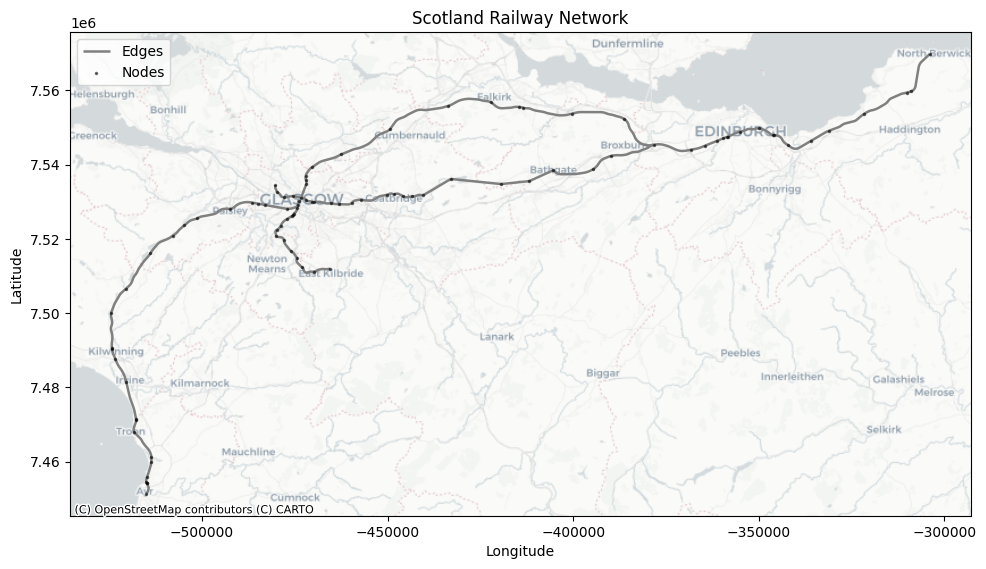

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import LineString
import pandas as pd
import time

start_time = time.time() 

# Define file paths
toy_node_path = r"D:\MINJI\NETWORK RELIABILITY\Data\datafiles\network\filtered\added\scotland_nodes.shp"
toy_edge_path = r"D:\MINJI\NETWORK RELIABILITY\Data\datafiles\network\filtered\added\scotland_edges.shp"

# Load the shapefiles
toy_node = gpd.read_file(toy_node_path)
toy_edge = gpd.read_file(toy_edge_path)

# Convert CRS to Web Mercator (EPSG:3857) for basemap compatibility
toy_edge = toy_edge.to_crs(epsg=3857)
toy_node = toy_node.to_crs(epsg=3857)

# Create a plot with network and basemap
fig, ax = plt.subplots(figsize=(10, 10))
toy_edge.plot(ax=ax, color="grey", linewidth=1.8, label="Edges")

node_coords = toy_node.geometry.apply(lambda pt: (pt.x, pt.y)).tolist()
x_coords, y_coords = zip(*node_coords)
ax.scatter(x_coords, y_coords, color="black", s=2.3, label="Nodes", zorder=3, alpha=0.5)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zorder=0)
plt.legend()
plt.title("Scotland Railway Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

====== Node info ======
n1 (ID: 3523): (-524470.99616, 7499986.438111)
n2 (ID: 3261): (-524276.187987, 7490410.144315)
n3 (ID: 3262): (-524273.234524, 7490470.566248)
n4 (ID: 2617): (-523360.887526, 7487672.349791)
n5 (ID: 1161): (-520452.696422, 7506586.872224)
n6 (ID: 511): (-520385.775818, 7481350.729956)
n7 (ID: 3695): (-518279.771931, 7467968.47467)
n8 (ID: 509): (-517765.285425, 7471464.185761)
n9 (ID: 510): (-517733.803915, 7471286.687783)
n10 (ID: 3700): (-514981.988333, 7454475.70141)
n11 (ID: 609): (-514949.140748, 7451315.609087)
n12 (ID: 608): (-514930.334358, 7454320.531268)
n13 (ID: 607): (-514826.238772, 7454082.609908)
n14 (ID: 2461): (-514785.239634, 7455846.222755)
n15 (ID: 1160): (-513899.576764, 7516055.544215)
n16 (ID: 2459): (-513661.668711, 7459898.061638)
n17 (ID: 2460): (-513643.656321, 7461296.331708)
n18 (ID: 1162): (-507867.506441, 7520819.045409)
n19 (ID: 305): (-504756.958128, 7523608.748936)
n20 (ID: 304): (-501317.686706, 7525481.789616)
n21 (ID: 306): (

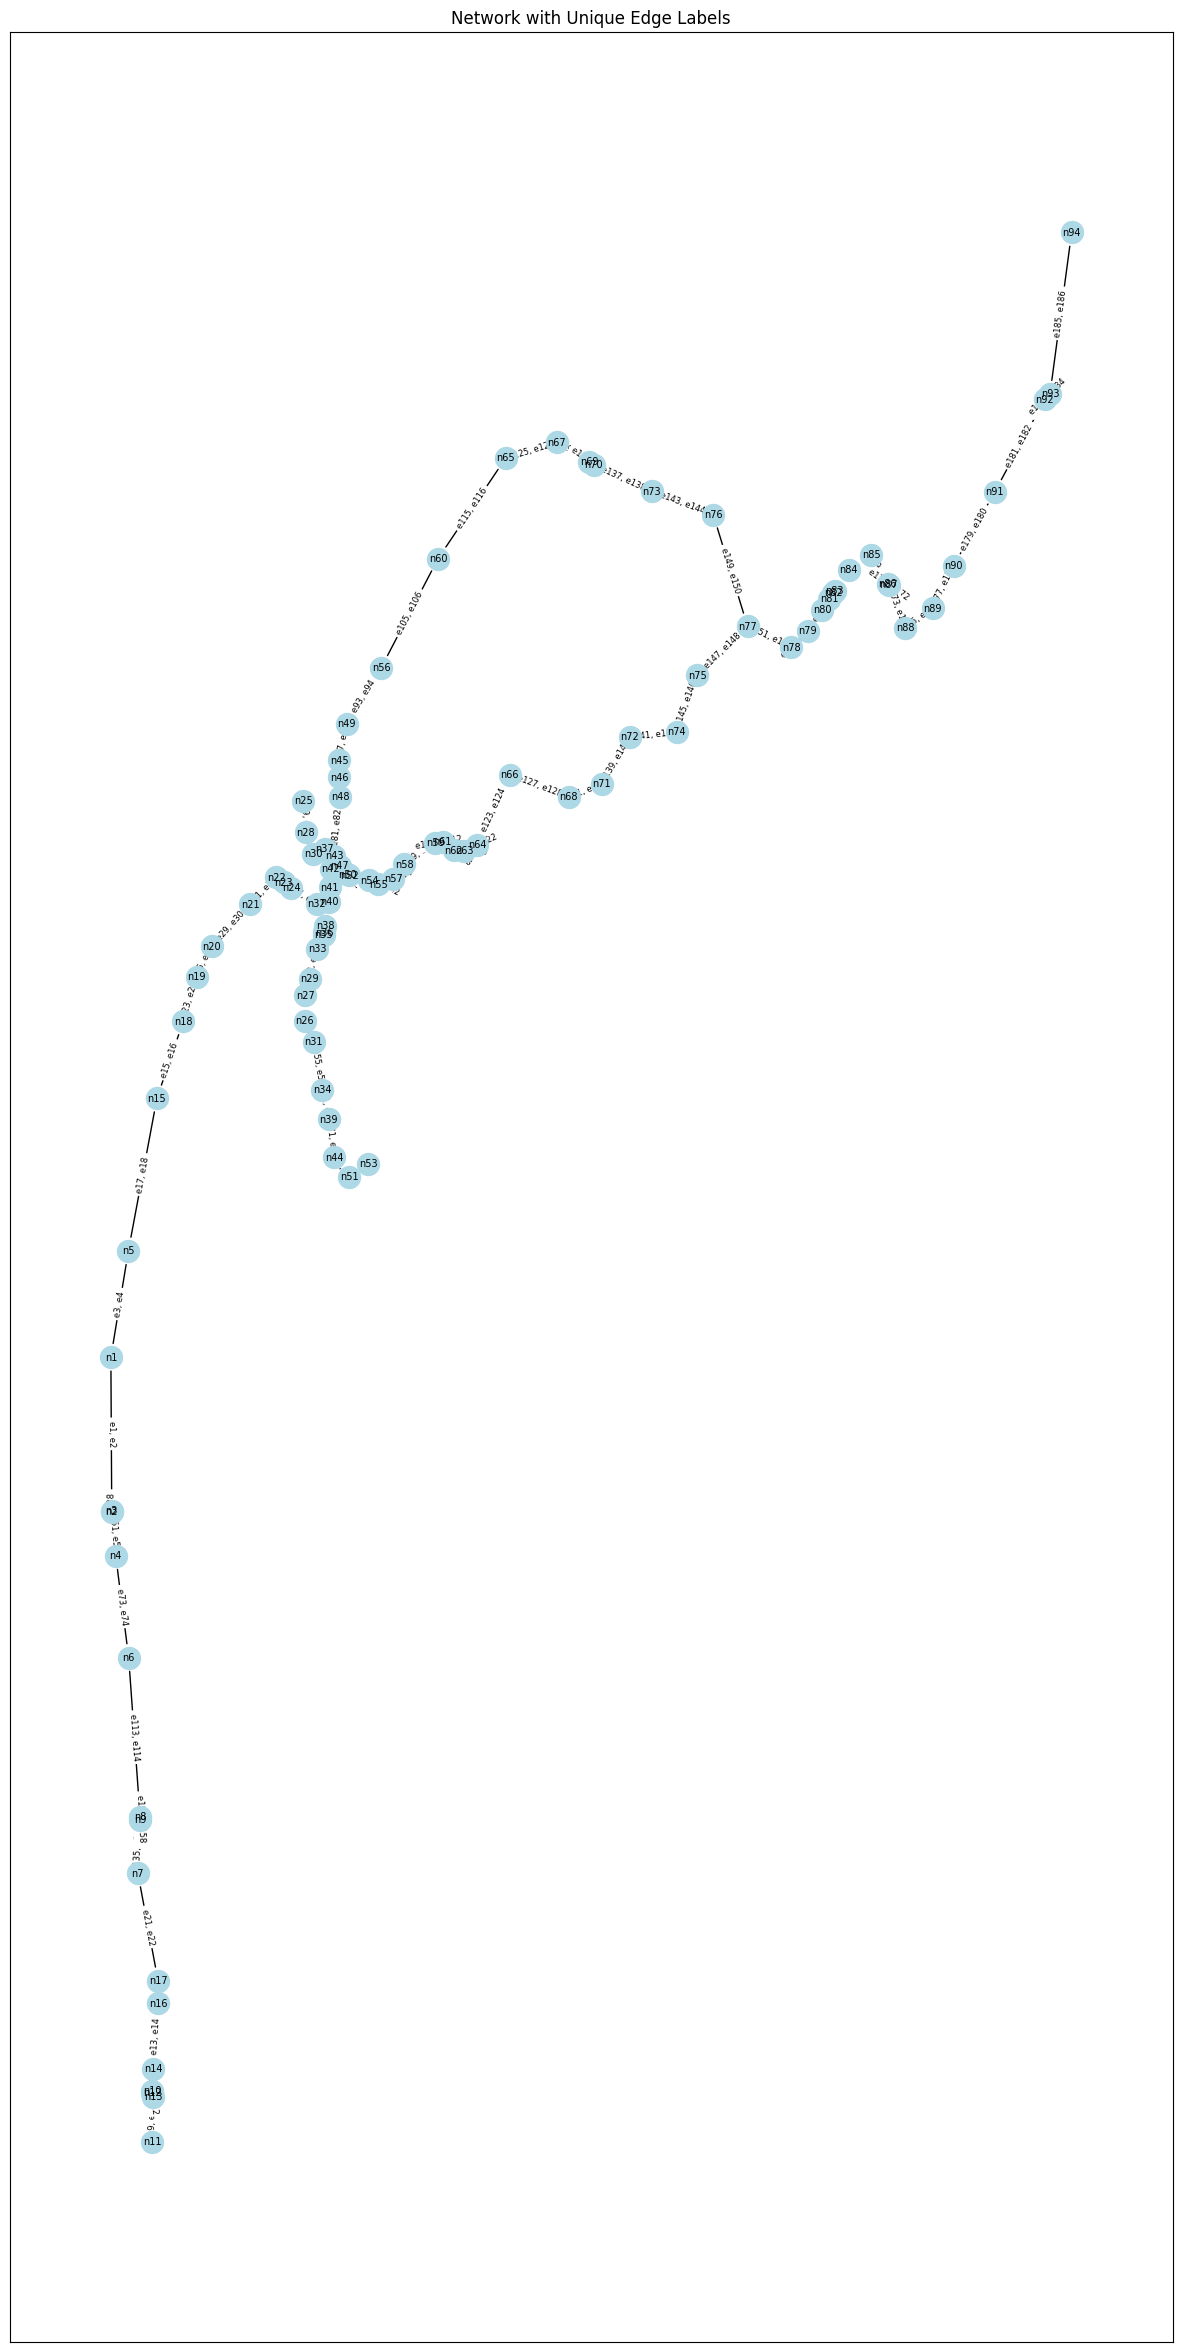

In [3]:
import networkx as nx



# 1. Node numbering (n1, n2, ...)
round_coord = lambda coord: (round(coord[0], 6), round(coord[1], 6))

node_info_list = [
    (row.node_id, round_coord((row.geometry.x, row.geometry.y)))
    for row in toy_node.itertuples()
]

sorted_node_info = sorted(node_info_list, key=lambda x: (x[1][0], -x[1][1]))

nodes = {}  
node_meta = [] 

for idx, (node_id, coord) in enumerate(sorted_node_info):
    node_name = f"n{idx + 1}"
    nodes[node_name] = coord
    node_meta.append({
        "node_id": node_id,
        "node_name": node_name,
        "geometry": coord  
    })

coord_to_node = {coord: node_name for node_name, coord in nodes.items()}

print("====== Node info ======")
for meta in node_meta:
    print(f"{meta['node_name']} (ID: {meta['node_id']}): {meta['geometry']}")



# 2. Edge numbering (e1, e2, ...)
nodeid_to_nodename = {meta["node_id"]: meta["node_name"] for meta in node_meta}
toy_edge['from_node_name'] = toy_edge['from_node_'].map(nodeid_to_nodename)
toy_edge['to_node_name'] = toy_edge['to_node_id'].map(nodeid_to_nodename)

edge_pairs = set()

for _, row in toy_edge.iterrows():
    from_node = row['from_node_name']
    to_node = row['to_node_name']
    sorted_pair = tuple(sorted([from_node, to_node]))
    edge_pairs.add(sorted_pair)

sorted_edge_pairs = sorted(edge_pairs, key=lambda x: (x[0], x[1]))
print(sorted_edge_pairs)

edges = {}
edge_number = 1

for from_node, to_node in sorted_edge_pairs:
    edges[f"e{edge_number}"] = (from_node, to_node)
    edges[f"e{edge_number + 1}"] = (to_node, from_node)
    edge_number += 2

edge_records = []
for edge_name, (from_node, to_node) in edges.items():
    match = toy_edge[((toy_edge['from_node_name'] == from_node) & (toy_edge['to_node_name'] == to_node)) |
                     ((toy_edge['from_node_name'] == to_node) & (toy_edge['to_node_name'] == from_node))]
    
    if not match.empty:
        journeys = match.iloc[0]['journeys']
        geometry = match.iloc[0]['geometry']
        edge_id = match.iloc[0]['edge_id']
    else:
        journeys = None
        geometry = None
        edge_id = None

    edge_records.append({
        'edge_id': edge_id,
        'edge_name': edge_name,
        'from_node_name': from_node,
        'to_node_name': to_node,
        'journeys': journeys,
        'geometry': geometry
    })

toy_edge_bidirectional = pd.DataFrame(edge_records)

toy_edge_bidirectional['edge_num'] = toy_edge_bidirectional['edge_name'].str.extract(r'e(\d+)').astype(int)
toy_edge_bidirectional = toy_edge_bidirectional.sort_values(by='edge_num').reset_index(drop=True)
toy_edge_bidirectional = toy_edge_bidirectional.drop(columns='edge_num')

print("\n====== Edge info ======")
pd.set_option('display.max_rows', None)
print(toy_edge_bidirectional)



# 3. Convert edges to arc format
arcs = [(u, v) for _, (u, v) in edges.items()]
#print("\nArcs:", arcs)



# 4. Compute Euclidean distances
def euclidean_distance(node1, node2):
    x1, y1 = nodes[node1]
    x2, y2 = nodes[node2]
    return round(((x2 - x1)**2 + (y2 - y1)**2)**0.5, 2)

arc_distance = {edge_name: euclidean_distance(u, v) for edge_name, (u, v) in edges.items()}
#print("Arc Distances:", arc_distance)



# 5. Create a network graph
# Create the graph using extracted data
G = nx.DiGraph()

# Add nodes and edges
for node, position in nodes.items():
    G.add_node(node, pos=position)

for edge_name, (u, v) in edges.items(): 
    G.add_edge(u, v, weight=arc_distance[edge_name])

# Remove duplicate edges
unique_edges = set()
edge_name_map = {}

for edge_name, (u, v) in edges.items():
    if (v, u) not in unique_edges:  
        unique_edges.add((u, v))
        reverse_edge_name = [k for k, (a, b) in edges.items() if (a, b) == (v, u)]  
        if reverse_edge_name:
            edge_label = f"{edge_name}, {reverse_edge_name[0]}"  
        else:
            edge_label = edge_name  
        
        edge_name_map[(u, v)] = edge_label  

# Plot the network topology
plt.figure(figsize=(15, 30))
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx_nodes(G, pos, node_size=250, node_color="lightblue")
nx.draw_networkx_edges(
    G, pos,
    edgelist=list(unique_edges),  
    arrowstyle='-',
    min_target_margin=10,
    min_source_margin=10
)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_name_map, font_size=6)
nx.draw_networkx_labels(G, pos, font_size=7)
plt.title("Network with Unique Edge Labels")
plt.show()


# Basic Settings
Generate Random Arc Capacity Value

In [4]:
import sys
import os
import gc
import re
import json
import copy

# Scientific Libraries
import numpy as np
from scipy.stats import beta

# Optimization
from gurobipy import Model, GRB, quicksum

# Graph & Plotting
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl

# MBNpy Modules
from mbnpy import brc, cpm, variable, operation, branch, config, trans

# Local Module
import batch

# Clean up memory
gc.collect()
%matplotlib inline


C:\Users\Minji Kang\AppData\Local\Temp\ipykernel_20644\4225336150.py:21: DeprecationWarning: operation.py is deprecated and replaced with inference.py. Please update your imports.
  from mbnpy import brc, cpm, variable, operation, branch, config, trans


In [5]:
nodes = nodes  
edges = edges  
arcs = arcs
arc_distance = arc_distance 



# 1. Generate arc failure probabilities based on arc distances (longer distance -> higher failure probability)
# Get the minimum and maximum arc distances
min_dist = min(arc_distance.values())
max_dist = max(arc_distance.values())

# Failure probability range (0.01 ~ 0.3)
min_prob = 0.01
max_prob = 0.3

def compute_failure_probability(distance, min_dist, max_dist, min_prob, max_prob):
    normalized_dist = (distance - min_dist) / (max_dist - min_dist) # Normalize to [0,1]
    return round(min_prob + normalized_dist * (max_prob - min_prob), 4)

# Generate failure probability for each edge
probs_dynamic = {
    edge: {
        0: compute_failure_probability(dist, min_dist, max_dist, min_prob, max_prob),
        1: round(1 - compute_failure_probability(dist, min_dist, max_dist, min_prob, max_prob), 4)
    }
    for edge, dist in arc_distance.items()
}

# Sort edges by numeric order
def numeric_sort(edge):
    return int(edge[1:])  # Extract numeric part from "eX"

probs_sorted = {k: probs_dynamic[k] for k in sorted(probs_dynamic, key=numeric_sort)}

# Print formatted probabilities
#print(json.dumps(probs_sorted, indent=4, separators=(",", ": ")))
probs = probs_sorted
probs_cpm = copy.deepcopy(probs)
#print(probs_cpm)



# 2. Assign capacities to each arcs
# Initial intact capacity (Unchanged from original)
intact_capacity = {}

for edge_name, (u, v) in edges.items():
    match = toy_edge[((toy_edge['from_node_name'] == u) & (toy_edge['to_node_name'] == v)) |
                     ((toy_edge['from_node_name'] == v) & (toy_edge['to_node_name'] == u))]

    if not match.empty:
        intact_capacity[edge_name] = match.iloc[0]['journeys']
    else:
        intact_capacity[edge_name] = None  

print("Intact Capacities:", intact_capacity)

# Function to generate random component states (0 or 1) based on failure probabilities
def generate_comps_st(probs):
    comps_st = {}

    for edge, prob in probs.items():
        if isinstance(prob, dict) and 0 in prob and 1 in prob:  # Ensure correct structure
            comps_st[edge] = np.random.choice([0, 1], p=[prob[0], prob[1]])
        else:
            print(f"Warning: Invalid probability format for edge {edge}: {prob}")  

    return comps_st

# Compute arc capacities
comps_st = generate_comps_st(probs_sorted)  



# 3. Compute maximum allowable distance
# Demand data
json_path = r"D:\MINJI\NETWORK RELIABILITY\Data\datafiles\network\filtered\added\demand_data.json"
with open(json_path, "r", encoding="utf-8") as f:
    demand = json.load(f)

# Compute max allowable distance
avg_velo = 149  # Speed in km/h
max_distance = {}
commodity_name_map = {}  

for idx, item in enumerate(demand, start=1):
    origin = item["origin"]
    destination = item["destination"]
    commodity_key = f"{origin}->{destination}"
    commodity_name = f"k{idx}"  

    distance = item["distance"]
    max_allowable_time = (distance * 60) / avg_velo + 180
    max_distance[commodity_name] = max_allowable_time * avg_velo / 60

    commodity_name_map[commodity_name] = {
        "key": commodity_key,
        "origin": origin,
        "destination": destination
    }

    print(f"\nCommodity: {commodity_name}")
    print(f"  OD Pair: {commodity_key}")
    print(f"  Distance (from JSON): {distance:.2f} km")
    print(f"  Maximum allowable time: {max_allowable_time:.2f} minutes")
    print(f"  Maximum allowable distance: {max_distance[commodity_name]:.2f} km")

Intact Capacities: {'e1': np.float64(8814.315698494403), 'e2': np.float64(8814.315698494403), 'e3': np.float64(9111.925674592298), 'e4': np.float64(9111.925674592298), 'e5': np.float64(2749.234783569382), 'e6': np.float64(2749.234783569382), 'e7': np.float64(2864.190504226538), 'e8': np.float64(2864.190504226538), 'e9': np.float64(2749.234783569382), 'e10': np.float64(2749.234783569382), 'e11': np.float64(2749.234783569382), 'e12': np.float64(2749.234783569382), 'e13': np.float64(2864.190504226538), 'e14': np.float64(2864.190504226538), 'e15': np.float64(9932.656571516694), 'e16': np.float64(9932.656571516694), 'e17': np.float64(9690.378661558021), 'e18': np.float64(9690.378661558021), 'e19': np.float64(3408.99728392566), 'e20': np.float64(3408.99728392566), 'e21': np.float64(3562.152830980634), 'e22': np.float64(3562.152830980634), 'e23': np.float64(10061.805190463), 'e24': np.float64(10061.805190463), 'e25': np.float64(10378.54001124812), 'e26': np.float64(10378.54001124812), 'e27': 

### Demand required for the network topology

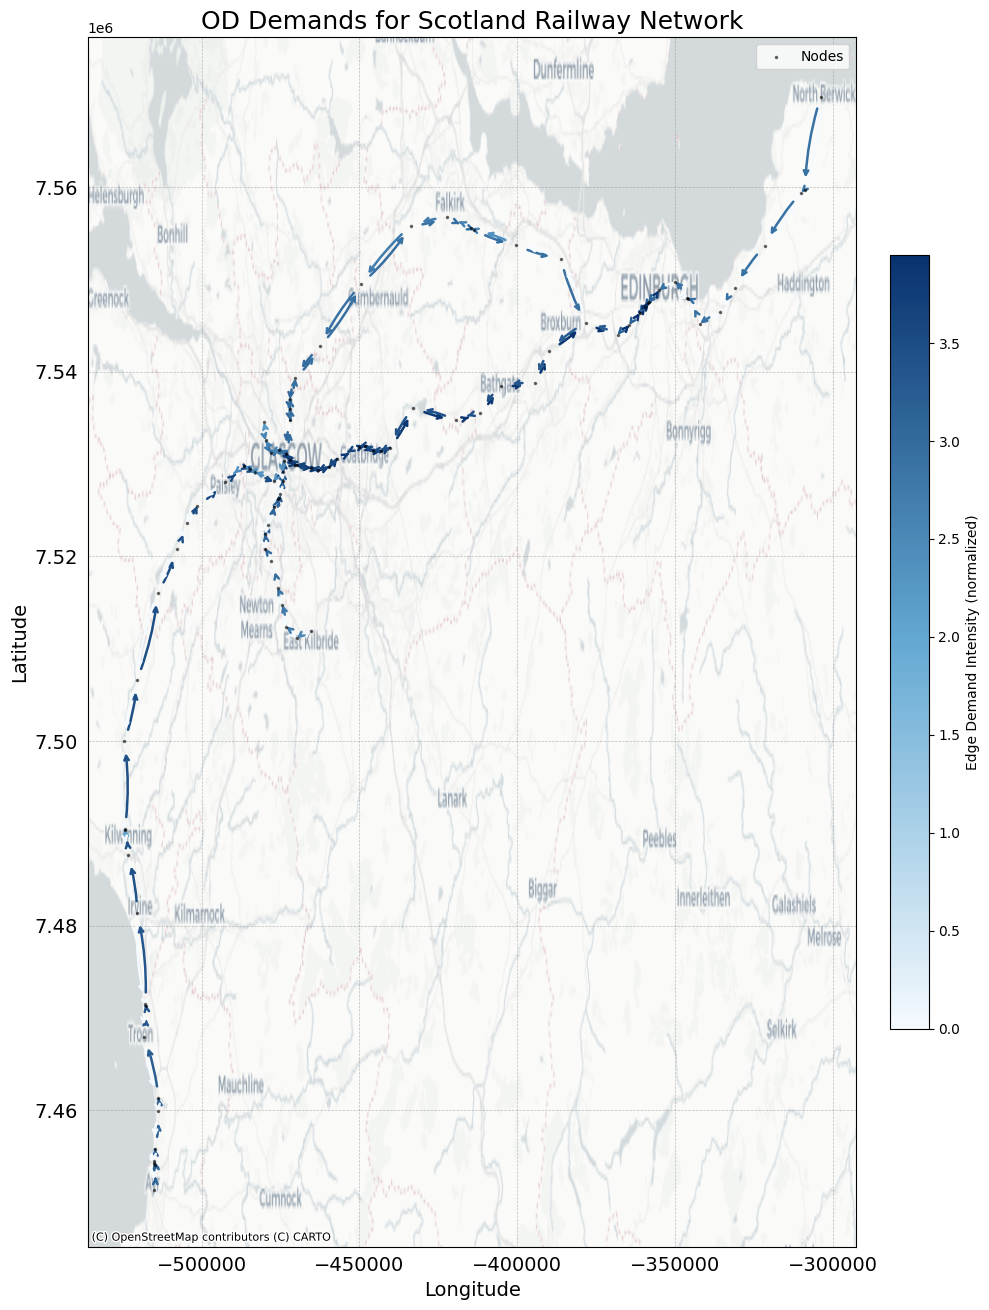

In [6]:
# Build directed graph with weighted arcs
G = nx.DiGraph()
for node, position in nodes.items():
    G.add_node(node, pos=position)

for edge_id, (u, v) in edges.items():
    G.add_edge(u, v, weight=arc_distance[edge_id])

# Initialize demand for each arc
edge_demand = { (u, v): 0 for u, v in G.edges }

# Accumulate demand from all shortest paths
for info in demand:
    origin = info["origin_name"]         # use node name like 'n18'
    destination = info["destination_name"]
    amount = info["journeys"]            # amount is stored as 'journeys'

    try:
        paths = list(nx.all_shortest_paths(G, source=origin, target=destination, weight="weight"))
        for path in paths:
            for i in range(len(path) - 1):
                edge = (path[i], path[i + 1])
                if edge in edge_demand:
                    edge_demand[edge] += amount
    except nx.NetworkXNoPath:
        print(f"⚠️ No path found for {origin} → {destination}")
        continue

# Log-scaled normalization
normalized_demand = {
    (u, v): np.log10(d + 1) for (u, v), d in edge_demand.items()
}
D_max = max(normalized_demand.values())
D_min = min(normalized_demand.values())

normalized_demand = {
    (u, v): (val - D_min) / (D_max - D_min)
    for (u, v), val in normalized_demand.items()
}

# Visualization
from matplotlib.colors import LinearSegmentedColormap
start_rgb = (245/255, 250/255, 254/255)    
mid_rgb   = (100/255, 169/255, 211/255)       
end_rgb   = (8/255, 50/255, 110/255)    
cmap = LinearSegmentedColormap.from_list("custom_3color_gradient", [start_rgb, mid_rgb, end_rgb])

pos = nx.get_node_attributes(G, "pos")
fig, ax = plt.subplots(figsize=(10, 13.2))

# Nodes
nx.draw_networkx_nodes(
    G, pos, node_size=2.3, node_color="black",
    alpha=0.5, ax=ax, label="Nodes"
)

# Edges with normalized demand
for (u, v), value in normalized_demand.items():
    color = cmap(value)
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)],
        width=1.8,
        edge_color=[color],
        arrowstyle="->",
        arrowsize=8,
        alpha=1,
        ax=ax,
        connectionstyle="arc3,rad=0.07"
    )

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs="EPSG:3857", zorder=0)
ax.tick_params(labelbottom=True, labelleft=True)
ax.set_axis_on()
ax.ticklabel_format(useOffset=False)

# Colorbar
norm = mpl.colors.Normalize(vmin=D_min, vmax=D_max)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Edge Demand Intensity (normalized)")

# Grid
ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=14, direction='out')
ax.set_axisbelow(True)  

plt.title("OD Demands for Scotland Railway Network", fontsize=18)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


# MCNF System Function

By using Gurobi solver

연결성만으로 시스템이 생존(sys_st = 's')한다고 평가하지 않고, 기대 손실(expected_loss)이 기준 이하일 때만 생존으로 간주
그렇다면 최소 생존 상태(min_comps_st)는 단순히 "연결만 되는 상태"를 의미하는 것이 아니라, "손실을 최소화하면서 운영이 가능한 상태"여야 함

In [ ]:
def MCNF_systemfunc(arcs, comps_st, edges, arc_capacity, demand, max_distance, arc_distance):
    from gurobipy import Model, GRB, quicksum
    import networkx as nx

    # Create a graph for shortest path calculations
    G = nx.Graph()
    for e, (i, j) in edges.items():
        G.add_edge(i, j, weight=arc_distance.get(e, 1))  # Set edge weights based on distance

    # Create Gurobi optimization model
    model = Model("Network Flow Optimization")
    model.setParam('OutputFlag', 0) 

    # Define variables
    flow = {}
    unmet_demand = {}

    for k, info in demand.items():
        unmet_demand[k] = model.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"unsatisfied_{k}")
        for i, j in arcs:
            arc_key = next((e for e, v in edges.items() if v == (i, j) or v == (j, i)), None)
            capacity = arc_capacity.get(arc_key, 0)
            flow[k, i, j] = model.addVar(lb=0, ub=capacity, vtype=GRB.CONTINUOUS, name=f"flow_{k}_{i}_{j}")

    # Objective function: Minimize expected loss
    model.setObjective(
        quicksum(unmet_demand[k] for k in demand),
        GRB.MINIMIZE
    )

    # Extract all nodes from edge values
    nodes = set(node for edge in edges.values() for node in edge)

    # Constraint 1: Flow conservation
    for k, info in demand.items():
        origin = info['origin']
        destination = info['destination']
        amount = info['amount']
        for node in nodes: 
            inflow = quicksum(flow[k, i, j] for i, j in arcs if j == node)
            outflow = quicksum(flow[k, i, j] for i, j in arcs if i == node)
            if node == origin:
                model.addConstr(outflow - inflow == amount - unmet_demand[k])
            elif node == destination:
                model.addConstr(outflow - inflow == - amount + unmet_demand[k])
            else:
                model.addConstr(outflow - inflow == 0)

    # Constraint 2: Arc capacity limits
    for i, j in arcs:
        arc_key = next((e for e, v in edges.items() if v == (i, j) or v == (j, i)), None)
        model.addConstr(quicksum(flow[k, i, j] for k in demand if (k, i, j) in flow) <= arc_capacity.get(arc_key, 0))

    # Constraint 3: Commodity별 max_distance 적용
    for k, info in demand.items():
        origin = info['origin']
        distance_expr = quicksum(arc_distance.get(e, 0) * flow[k, i, j] for e, (i, j) in edges.items() if (k, i, j) in flow)
        total_flow = quicksum(flow[k, i, j] for i, j in arcs if (k, i, j) in flow and i == origin)
        
        model.addConstr(distance_expr <= max_distance[k] * total_flow)

    # Perform optimization
    model.optimize()

    # Process results
    if model.status == GRB.OPTIMAL:
        expected_loss = model.objVal

        if expected_loss < 23004.16:
            sys_st = 's'

            # We can infer an associated minimum survival rule in case of network connectivity.
            min_comps_st = {}

            # Extract used links from optimization result
            for (k, i, j), var in flow.items():
                if var.x > 0:  # If flow is greater than 0, the edge is used in the solution
                    link_name = next((e for e, v in edges.items() if v == (i, j) or v == (j, i)), None)
                    if link_name:
                        min_comps_st[link_name] = 1  # Store as {e1: 1, e2: 1}

        else:
            sys_st = 'f'
            min_comps_st = None  # No survival rule needed for failed state
        
        # print(f"Expected Loss: {expected_loss:.2f}")
        # print(f"System state: {sys_st}")
        # print(f"Component states: {comps_st}")
        # print(f"Number of failed components: {sum(1 for v in comps_st.values() if v == 0)}")

        num_failed_zero_capacity = sum(
            1 for comp, state in comps_st.items()
            if state == 0 and arc_capacity.get(comp, 1) == 0
        )
        # print(f"Number of failed components with capacity = 0: {num_failed_zero_capacity}")


        return expected_loss, sys_st, min_comps_st  

    else:
        return None, None, None  


Run MCNF system function

In [8]:
demand_dict = {}

for idx, item in enumerate(demand, start=1):
    key = f"k{idx}"
    demand_dict[key] = {
        "origin": item["origin_name"],
        "destination": item["destination_name"],
        "amount": item["journeys"],    
        "distance": item["distance"]
    }


sys_fun = lambda comps_st: MCNF_systemfunc(
    arcs=arcs,
    comps_st=comps_st,
    edges=edges,
    arc_capacity={e: int(intact_capacity[e] * comps_st[e]) for e in comps_st},
    demand=demand_dict,
    max_distance=max_distance,
    arc_distance=arc_distance
)

# test 1
test_comps_st1 = {e: 0 for e in edges.keys()}
expected_loss1, sys_st1, _ = sys_fun(test_comps_st1)

# test 2
test_comps_st2 = {e: 1 for e in edges.keys()}
expected_loss2, sys_st2, _ = sys_fun(test_comps_st2)


Set parameter Username
Set parameter LicenseID to value 2637066
Academic license - for non-commercial use only - expires 2026-03-16
Expected Loss: 25301.78
System state: f
Component states: {'e1': 0, 'e2': 0, 'e3': 0, 'e4': 0, 'e5': 0, 'e6': 0, 'e7': 0, 'e8': 0, 'e9': 0, 'e10': 0, 'e11': 0, 'e12': 0, 'e13': 0, 'e14': 0, 'e15': 0, 'e16': 0, 'e17': 0, 'e18': 0, 'e19': 0, 'e20': 0, 'e21': 0, 'e22': 0, 'e23': 0, 'e24': 0, 'e25': 0, 'e26': 0, 'e27': 0, 'e28': 0, 'e29': 0, 'e30': 0, 'e31': 0, 'e32': 0, 'e33': 0, 'e34': 0, 'e35': 0, 'e36': 0, 'e37': 0, 'e38': 0, 'e39': 0, 'e40': 0, 'e41': 0, 'e42': 0, 'e43': 0, 'e44': 0, 'e45': 0, 'e46': 0, 'e47': 0, 'e48': 0, 'e49': 0, 'e50': 0, 'e51': 0, 'e52': 0, 'e53': 0, 'e54': 0, 'e55': 0, 'e56': 0, 'e57': 0, 'e58': 0, 'e59': 0, 'e60': 0, 'e61': 0, 'e62': 0, 'e63': 0, 'e64': 0, 'e65': 0, 'e66': 0, 'e67': 0, 'e68': 0, 'e69': 0, 'e70': 0, 'e71': 0, 'e72': 0, 'e73': 0, 'e74': 0, 'e75': 0, 'e76': 0, 'e77': 0, 'e78': 0, 'e79': 0, 'e80': 0, 'e81': 0, 'e82': 0

# Expected Loss Evaluation
By BRC algorithm

In [9]:
# 두 expected loss 값
loss1 = 25301.78
loss2 = 2325.62

# 정렬 (작은 값부터)
low, high = sorted([loss1, loss2])

# 전체 범위
range_total = high - low

# 하위 95% 구간
lower_bound = low
upper_bound = low + 0.9 * range_total

print(f"📉 95% 하위 구간: [{lower_bound:.2f}, {upper_bound:.2f}]")


📉 95% 하위 구간: [2325.62, 23004.16]


In [10]:
# Run BRC with stopping criteria (max_rules = 100)
brs, rules, sys_res, monitor = brc.run(
    probs=probs, 
    sys_fun=sys_fun, 
    max_sf=np.inf, 
    max_nb=np.inf, 
    pf_bnd_wr=0.0, 
    max_rules=100,  
    active_decomp=10,
    display_freq=5,
    brs=[],
)

# Check if BRC stopped due to max_rules
if len(rules['s'] + rules['f']) >= 100:
    print("\n🔹 BRC terminated because 100 rules have been found.")

# System failure probability
P_f = sum(branch.p for branch in brs if branch.down_state == 'f')
print(f"System Failure Probability (P_f): {P_f}")

# Identify failure / unknown branches (brs_u)
brs_u = [branch for branch in brs if branch.down_state == 'u' or branch.up_state == 'u']
brs_f = [branch for branch in brs if branch.down_state == 'f' and branch.up_state == 'f']

print(brs_f)
print(f"Number of failure branches: {len(brs_f)}")

print(rules)

Expected Loss: 2325.62
System state: s
Component states: {'e1': 1, 'e2': 1, 'e3': 1, 'e4': 1, 'e5': 1, 'e6': 1, 'e7': 1, 'e8': 1, 'e9': 1, 'e10': 1, 'e11': 1, 'e12': 1, 'e13': 1, 'e14': 1, 'e15': 1, 'e16': 1, 'e17': 1, 'e18': 1, 'e19': 1, 'e20': 1, 'e21': 1, 'e22': 1, 'e23': 1, 'e24': 1, 'e25': 1, 'e26': 1, 'e27': 1, 'e28': 1, 'e29': 1, 'e30': 1, 'e31': 1, 'e32': 1, 'e33': 1, 'e34': 1, 'e35': 1, 'e36': 1, 'e37': 1, 'e38': 1, 'e39': 1, 'e40': 1, 'e41': 1, 'e42': 1, 'e43': 1, 'e44': 1, 'e45': 1, 'e46': 1, 'e47': 1, 'e48': 1, 'e49': 1, 'e50': 1, 'e51': 1, 'e52': 1, 'e53': 1, 'e54': 1, 'e55': 1, 'e56': 1, 'e57': 1, 'e58': 1, 'e59': 1, 'e60': 1, 'e61': 1, 'e62': 1, 'e63': 1, 'e64': 1, 'e65': 1, 'e66': 1, 'e67': 1, 'e68': 1, 'e69': 1, 'e70': 1, 'e71': 1, 'e72': 1, 'e73': 1, 'e74': 1, 'e75': 1, 'e76': 1, 'e77': 1, 'e78': 1, 'e79': 1, 'e80': 1, 'e81': 1, 'e82': 1, 'e83': 1, 'e84': 1, 'e85': 1, 'e86': 1, 'e87': 1, 'e88': 1, 'e89': 1, 'e90': 1, 'e91': 1, 'e92': 1, 'e93': 1, 'e94': 1, 'e95': 1, '

## **Functions for Reliability Index and Redundancy Index**
#### **Beta Calculation**
$$
\beta_{ij} = -\Phi^{-1}\left(P(F_i \mid H_j)\right)
$$

In [11]:
def compute_beta_for_combination(probs, X_n):
    failure_probs = [probs[x][0] for x in X_n]
    beta_values = [-norm.ppf(p) for p in failure_probs]
    
    if len(beta_values) == 1:
        joint_prob = failure_probs[0]
        joint_beta = beta_values[0]
    else:
        mean = np.zeros(len(beta_values))
        cov = np.identity(len(beta_values))  
        joint_prob = multivariate_normal.cdf(-np.array(beta_values), mean=mean, cov=cov)
        joint_beta = -norm.ppf(joint_prob) if joint_prob > 0 else float("inf")
    
    return {
        "State": X_n,
        "Failure Probability": joint_prob,
        "Beta": joint_beta
    }

#### **Pi Calculation**

$$
\begin{align*}
\pi_{ij} & = -\Phi^{-1}\left(P(F_{\text{sys}} \mid F_i, H_j)\right) \\
         & = -\Phi^{-1}\left(\frac{P(F_{\text{sys}}, F_i)}{P(F_i)}\right) \\
         & = -\Phi^{-1}\left(
         \frac{
         \sum_{b = (\boldsymbol{l}, \boldsymbol{u}, p) \in B_f : \boldsymbol{u}\langle X_i \rangle = 0} p
         + \sum_{b = (\boldsymbol{l}, \boldsymbol{u}, p) \in B_f : \boldsymbol{u}\langle X_i \rangle = 1 \text{ and } \boldsymbol{l}\langle X_i \rangle = 0} \left(p \cdot P(F_i)\right)
         + \sum_{b = (\boldsymbol{l}, \boldsymbol{u}, p) \in B_f : \boldsymbol{u}\langle X_i \rangle = 1 \text{ and } \boldsymbol{l}\langle X_i \rangle = 1} 0
         }{P(F_i)}
         \right)
\end{align*}
$$

In [12]:
import importlib
import batch

importlib.reload(batch)

def sys_fun_rs(sample):
    val, sys_st, _ = sys_fun(sample)
    return val, sys_st

In [13]:
def compute_pi_for_combination(X_n, probs_cpm, brs_f, brs_u, sys_fun, sys_fun_rs):
    import batch

    P_Xn_0 = [probs_cpm[x][0] for x in X_n]
    P_Xi_0 = np.prod(P_Xn_0)

    # 필터링
    failure_known_branch1, unknown_branch1 = batch.eventspace_multi_x0_filter(brs_u, X_n, P_Xn_0, sys_fun)
    total_prob_failure1 = batch.compute_total_probability(failure_known_branch1)
    B_f = [b for b in brs_f if b.up_state == 'f' and batch.is_xn_all_0(b, X_n)]
    brc_failure_prob1 = batch.compute_total_probability(B_f)

    # MCS
    failure_prob1 = brc_failure_prob1 + total_prob_failure1
    mcs_result = batch.run_mcs_for_unknown_branch(
        brs_u=brs_u,
        unknown_branch=unknown_branch1,
        probs=probs_cpm,
        sys_fun_rs=sys_fun_rs,
        cov_t=0.05, # 원래 0.01이었음
        sys_st_monitor=1,
        failure_prob=failure_prob1,
        rand_seed=None
    )

    joint_prob = mcs_result['pf']
    pi_ratio = joint_prob / P_Xi_0

    # π_ij 계산
    if pi_ratio >= 1 and pi_ratio < 1.01:
        pi_ij = -3
    elif pi_ratio >= 1.01 or pi_ratio <= 0:
        pi_ij = float('inf')
    else:
        pi_ij = -norm.ppf(pi_ratio)
        if pi_ij < -3:
            pi_ij = -3

    return {
        "State": X_n,
        "P(Fsys | state)": pi_ratio,
        "π_ij": pi_ij
    }

In [ ]:
from itertools import combinations
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. 조합 생성
MAX_COMB_SIZE = 2
component_names = list(probs.keys())
component_combinations = []

for k in range(1, MAX_COMB_SIZE + 1):
    component_combinations.extend(list(combinations(component_names, k)))

# 2. 값 저장 리스트
beta_values, pi_values, state_labels, failed_elements = [], [], [], []

# 3. 실시간 플롯 설정
plt.ion()  # 인터랙티브 모드 켜기
fig, ax = plt.subplots(figsize=(8, 8))

# 등고선 (Threshold lines) 고정적으로 그려놓기
prob_targets = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
reverse_labels = [r'$\lambda_{H_j} = 10^{-5}$/year', r'$\lambda_{H_j} = 10^{-4}$/year',
                  r'$\lambda_{H_j} = 10^{-3}$/year', r'$\lambda_{H_j} = 10^{-2}$/year',
                  r'$\lambda_{H_j} = 10^{-1}$/year']
line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]

for prob_target, line_style, label in zip(prob_targets, line_styles, reverse_labels):
    beta_threshold = np.arange(-3, 8, 1e-4)
    pi_threshold = -norm.ppf(prob_target / norm.cdf(-beta_threshold))
    ax.plot(pi_threshold, beta_threshold, 'black', linestyle=line_style,
            linewidth=2, label=label, alpha=0.8, zorder=1)

# 색상 및 마커 정의
colors = [(84/255, 102/255, 142/255),
          (54/255, 57/255, 85/255),
          (135/255, 138/255, 198/255)]
markers = ['o', '^', 's']

save_dir = r"D:\MINJI\NETWORK RELIABILITY\Meeting\Figure"
os.makedirs(save_dir, exist_ok=True)  # 폴더가 없으면 자동 생성

# 4. 조합별로 계산 + 실시간 플롯
for idx, X_n in enumerate(component_combinations):
    print(f"▶ Computing for combination {idx+1}/{len(component_combinations)}: {X_n}")
    
    beta_result = compute_beta_for_combination(probs, X_n)
    pi_result = compute_pi_for_combination(X_n, probs_cpm, brs_f, brs_u, sys_fun, sys_fun_rs)

    β = beta_result['Beta']
    π = pi_result['π_ij']
    k = len(X_n)

    beta_values.append(β)
    pi_values.append(π)
    state_labels.append(",".join(X_n))
    failed_elements.append(k)

    print(f"[{X_n}] → Beta: {β:.4f}, Pi: {π:.4f}")

    # 🔄 5개마다 또는 마지막 조합일 때 plot
    if (idx + 1) % 2 == 0 or (idx + 1) == len(component_combinations):
        fig, ax = plt.subplots(figsize=(8, 8))

        # 등고선
        beta_threshold = np.arange(-3, 8, 1e-4)
        for prob_target, line_style, label in zip(prob_targets, line_styles, reverse_labels):
            pi_threshold = -norm.ppf(prob_target / norm.cdf(-beta_threshold))
            ax.plot(pi_threshold, beta_threshold, 'black', linestyle=line_style,
                    linewidth=2, label=label, alpha=0.8, zorder=1)

        # 지금까지의 누적 점 그림
        for b, p, lbl, kk in zip(beta_values, pi_values, state_labels, failed_elements):
            color = colors[kk - 1]
            marker = markers[kk - 1]
            ax.scatter(p, b, color=color, s=100, edgecolors='k', marker=marker, zorder=3)
            ax.text(p + 0.05, b + 0.05, lbl, fontsize=8, alpha=0.8)

        ax.set_title(r'$\beta$–$\pi$ Diagram: System Evaluation via BRC', fontsize=16)
        ax.set_xlabel("Redundancy (π)", fontsize=12)
        ax.set_ylabel("Reliability (β)", fontsize=12)
        ax.set_xlim([-3, 5])
        ax.set_ylim([-2, 6])
        ax.grid(alpha=0.5)
        ax.legend(title="Failure Thresholds", fontsize=9, loc='lower left')
        plt.tight_layout()

        # ✅ 저장 파일 이름
        filename = f"beta_pi_plot_{idx+1}.jpeg"
        filepath = os.path.join(save_dir, filename)

        # ✅ 저장
        fig.savefig(filepath, dpi=300, format='jpeg')
        plt.close(fig)